# Analyzing Neural Time Series Data: Chapter 20

### Differences among Total, Phase-locked, and Non-phase-locked Power and Intertrial Phase Consistency

Converted from MATLAB to Python by Andrew J. Graves on 03/05/20

In [1]:
# Get matplotlib magic
%matplotlib notebook 

# Import modules
import numpy as np
import matplotlib.pyplot as plt

# Run data extraction and useful function script; double quotes work for Windows and Mac paths
%run "data_and_funcs.ipynb"

### Figure 20.1

<IPython.core.display.Javascript object>


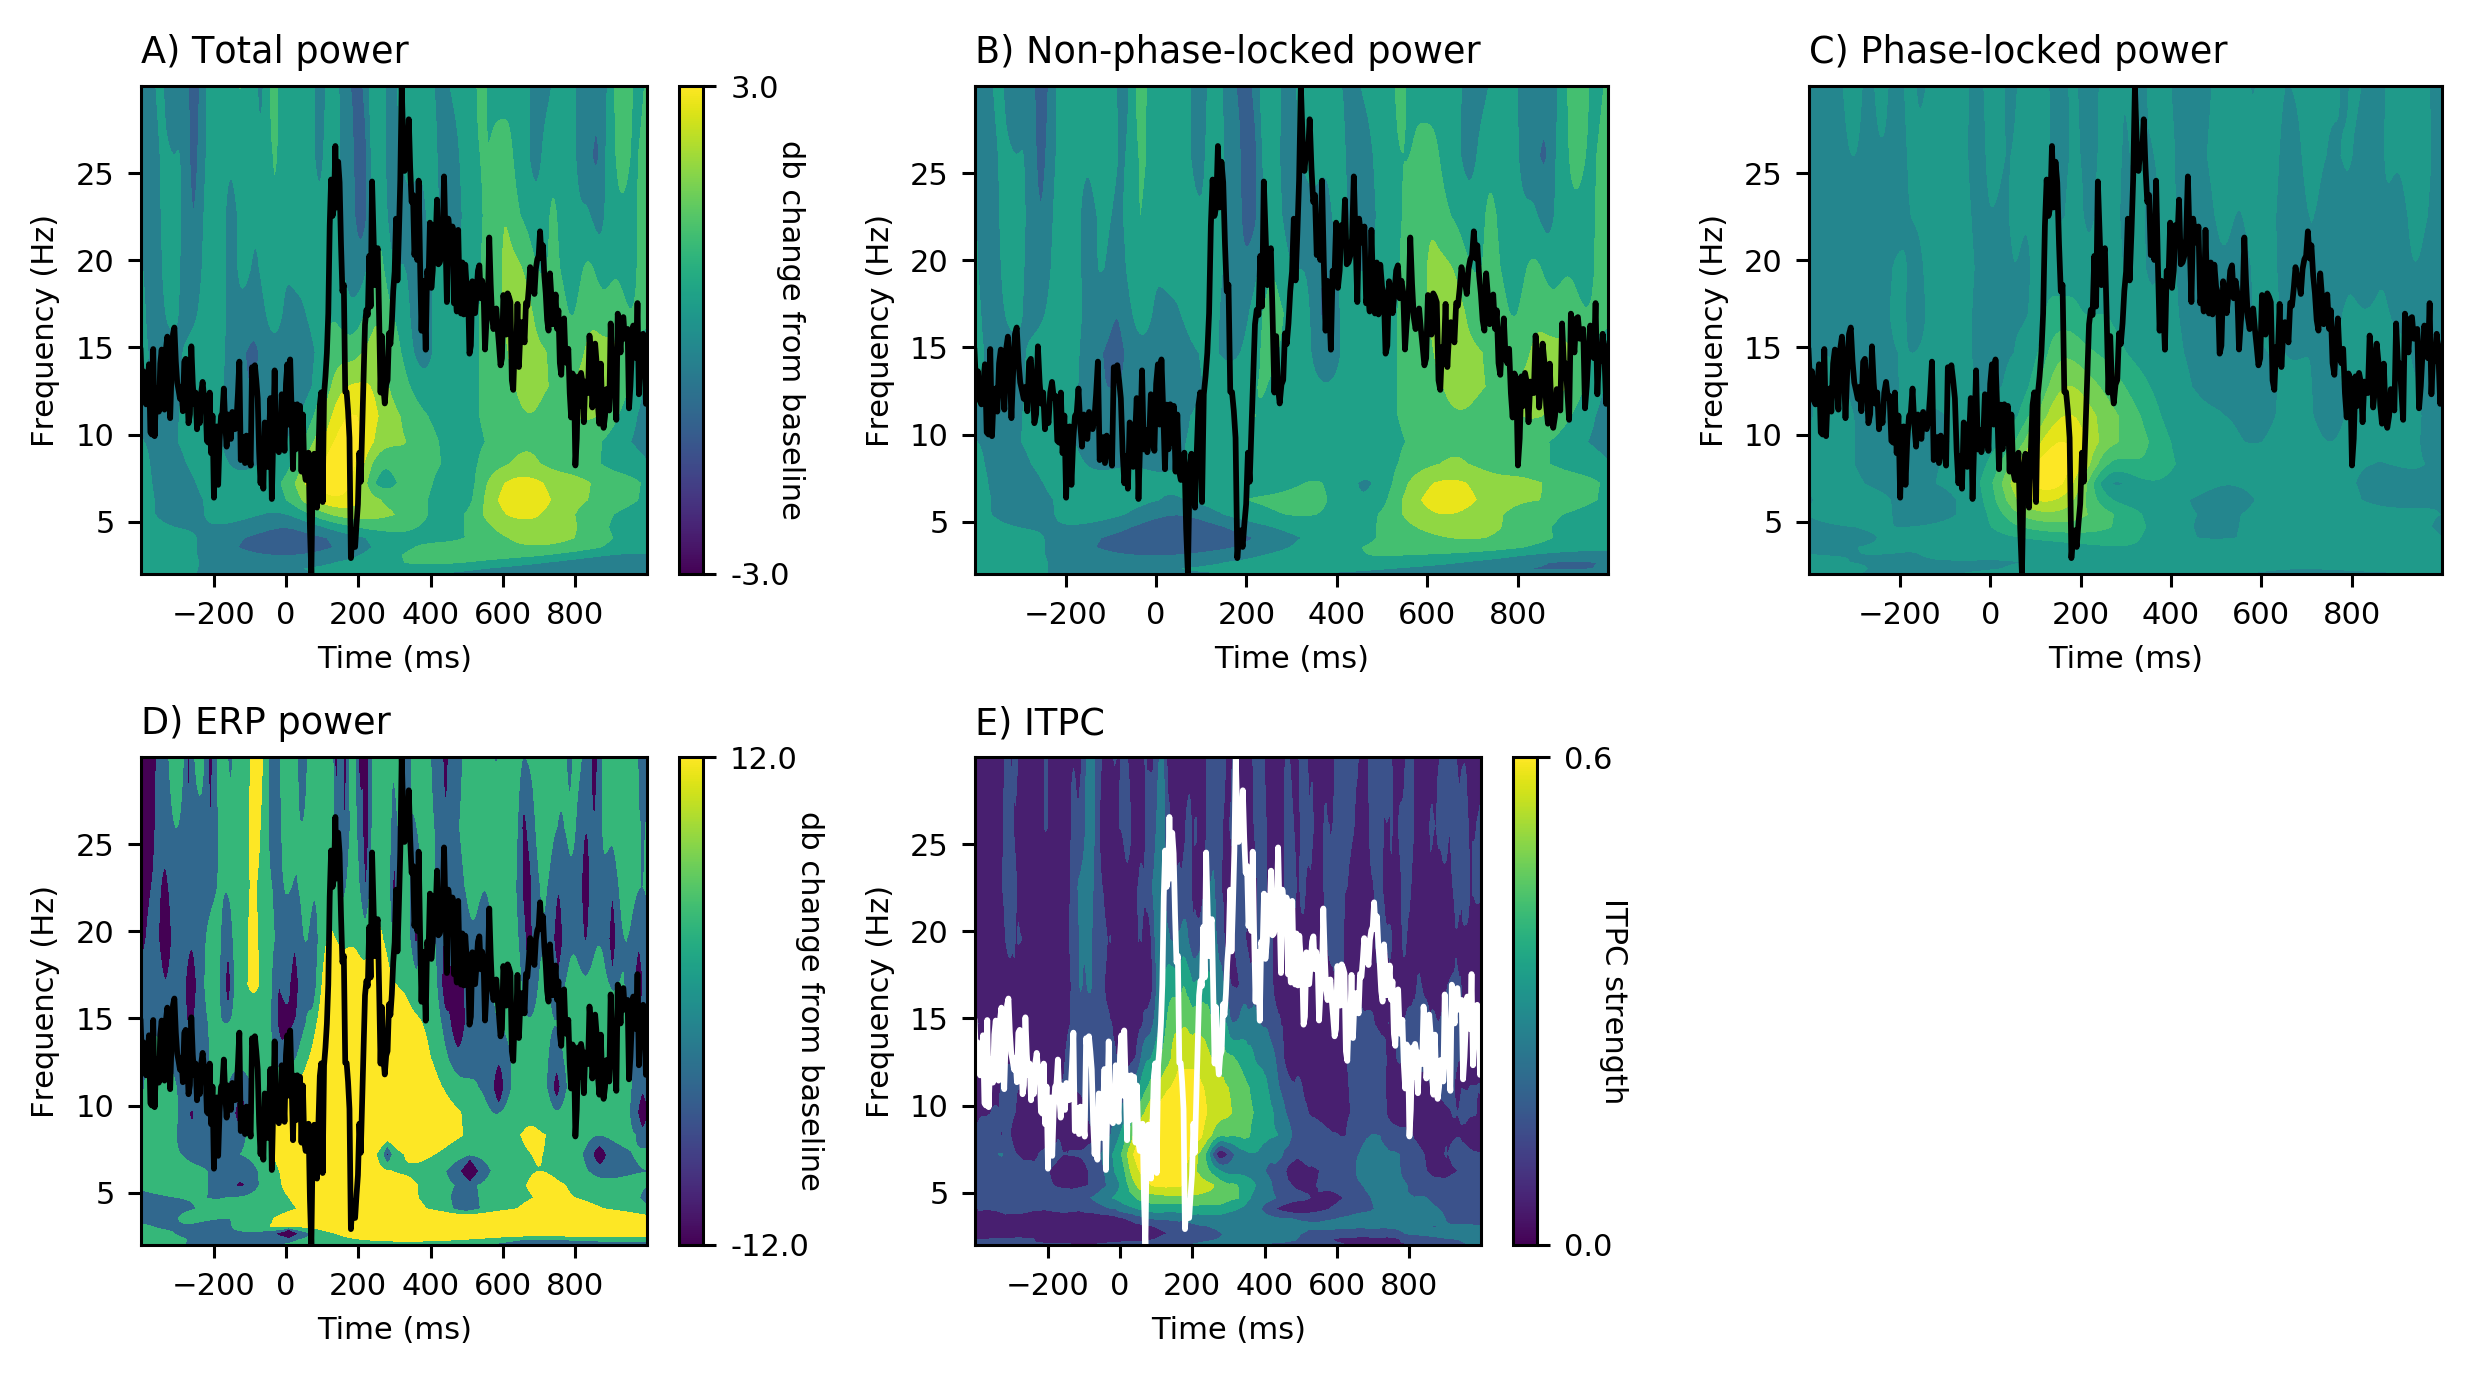

In [2]:
plt.rc('font', size=8)

chan_to_plot = 'O1';
chan_index = [index for index, item in enumerate(chan_names) if item == chan_to_plot]
min_freq = 2
max_freq = 30
n_freqs = 20
time = time_series(samp_rate)

# Specify baseline time window
baseline_time = [-400, -100]

# Wavelet and FFT parameters
n_conv = np.zeros(3)
freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
half_of_wavelet = (len(time) - 1) // 2
n_wavelet = len(time)
n_data = np.shape(eeg_data)[1] * np.shape(eeg_data)[2]
n_conv = np.zeros(3)
n_conv[0:2] = n_wavelet + n_data - 1
n_conv[2] = n_wavelet + np.shape(eeg_data)[1] - 1 #ERP is only one trial-length

# Compute ERP
erp = get_erp(eeg_data, chan_to_plot)

# Compute induced power by subtracting ERP from each trial
induced_eeg = np.squeeze(eeg_data[chan_index, :, :]) - np.tile(erp, [np.shape(eeg_data)[2], 1]).T

# Initialize FFT matrix
fft_eeg = np.zeros([2, int(n_conv[0])], dtype=complex)

# Total
fft_eeg[0, :] = np.fft.fft(np.reshape(eeg_data[chan_index, :, :], [1, n_data], order='F'), n_conv[0])
# Induced (non-phase locked)
fft_eeg[1, :] = np.fft.fft(np.reshape(induced_eeg, [1, n_data], order='F'), n_conv[1],)
# Evoked (ERP)
fft_erp = np.fft.fft(erp, n_conv[2])

# Convert baseline from ms to indices
base_idx = np.zeros(2)
for i in range(len(base_idx)):
    base_idx[i] = np.where(np.abs(eeg_time - baseline_time[i]) == np.min(np.abs(eeg_time - baseline_time[i])))[0]

# Initialize the time-frequency output array
tf = np.zeros([5, len(freqs), np.shape(eeg_data)[1]], dtype=complex)

# Iterate and analyze at various frequencies
for i in range(len(freqs)):
    
    # Create wavelet
    wavelet = get_sine_wave(freqs[i], samp_rate, complex_wave=True) * gauss_win(
        freqs[i], samp_rate, num_cycle=4, normalize=True)
    
    # Run convolution for each total, induced, and evoked
    for j in range(len(n_conv)):
        
        fft_wavelet = np.fft.fft(wavelet, n_conv[j])
    
        # Compute and slice the convolution result
        if j < 2:
            # Reshaping and trial averaging is done only on trial-level data
            temp_conv_res_fft = np.fft.ifft(fft_wavelet * fft_eeg[j, :], n_conv[j])
            temp_conv_res_fft = temp_conv_res_fft[half_of_wavelet:len(temp_conv_res_fft) - half_of_wavelet]
            conv_res_fft = np.reshape(temp_conv_res_fft, [np.shape(eeg_data)[1], np.shape(eeg_data)[2]], order='F')
            tf[j, i, :] = np.mean(np.abs(conv_res_fft) ** 2, 1)
        else:
            # With ERP, just compute power with no averaging
            temp_conv_res_fft = np.fft.ifft(fft_wavelet * fft_erp, n_conv[j])
            conv_res_fft = temp_conv_res_fft[half_of_wavelet:len(temp_conv_res_fft) - half_of_wavelet]
            tf[j, i, :] = np.abs(conv_res_fft) ** 2
        
        # DB correct power
        tf[j, i, :] = 10 * np.log10(np.squeeze(tf[j, i, :]) / np.mean(tf[j, i, int(base_idx[0]):int(base_idx[1])+1]))
        
        # Inter-trial phase consistency on total EEG
        if j == 0:
            tf[4, i, :] = np.abs(np.mean(np.exp(1j * np.angle(conv_res_fft)), 1))

# Move ERP power to index 3 for plotting purposes
tf[3, :, :] = tf[2, :, :]

# Compute phase-locked power and assign to index 2 for plotting purposes
tf[2, :, :] = np.squeeze(tf[0, :, :]) - np.squeeze(tf[1, :, :])
            
# Figure 20.1 ----------

titles = ['Total power', 'Non-phase-locked power', 'Phase-locked power', 'ERP power', 'ITPC']
# Color limits
clims = np.array([[-3, 3], [-3, 3], [-3, 3], [-12, 12], [0, .6]])

# Scale ERP for plotting
temp_erp = (erp - np.min(erp)) / np.max(erp - np.min(erp))
erpt = temp_erp * (freqs[-1] - freqs[0]) + freqs[0]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))

j = 0
for i in ax.flatten()[0:5]:
    image = i.contourf(eeg_time, freqs, np.real(np.squeeze(tf[j, :, :])), vmin=clims[j, 0], vmax=clims[j, 1])
    m = plt.cm.ScalarMappable()
    m.set_array(np.squeeze(tf[j, :, :]))
    m.set_clim(clims[j])
    
    # Overlay the ERP
    if j < 4:
        col = 'black'
    else: 
        col = 'white'
    i.plot(eeg_time, erpt, color=col)
    
    # Set colorbars
    if j not in [1, 2]:
        if j == 4:
            color_lab = 'ITPC strength'
        else: 
            color_lab = 'db change from baseline'

        cbar = fig.colorbar(m, ax=i, boundaries=np.arange(clims[j, 0], clims[j, 1] + .001, .001))
        cbar.set_ticks(clims[j])
        cbar.set_ticklabels(clims[j])
        cbar.set_label(color_lab, rotation=270)
    
    # Set plot parameters
    i.set_xlim([-400, 1000])
    i.set_xticks(np.arange(-200, 801, 200))
    i.set_yticks(np.arange(5, 30 ,5))
    i.set_xlabel('Time (ms)')
    i.set_ylabel('Frequency (Hz)')
    i.set_title(pos_to_char(j) + ') ' + titles[j], loc='left')
    
    j += 1

ax[-1, -1].axis('off')
fig.tight_layout()

### Figure 20.2

<IPython.core.display.Javascript object>


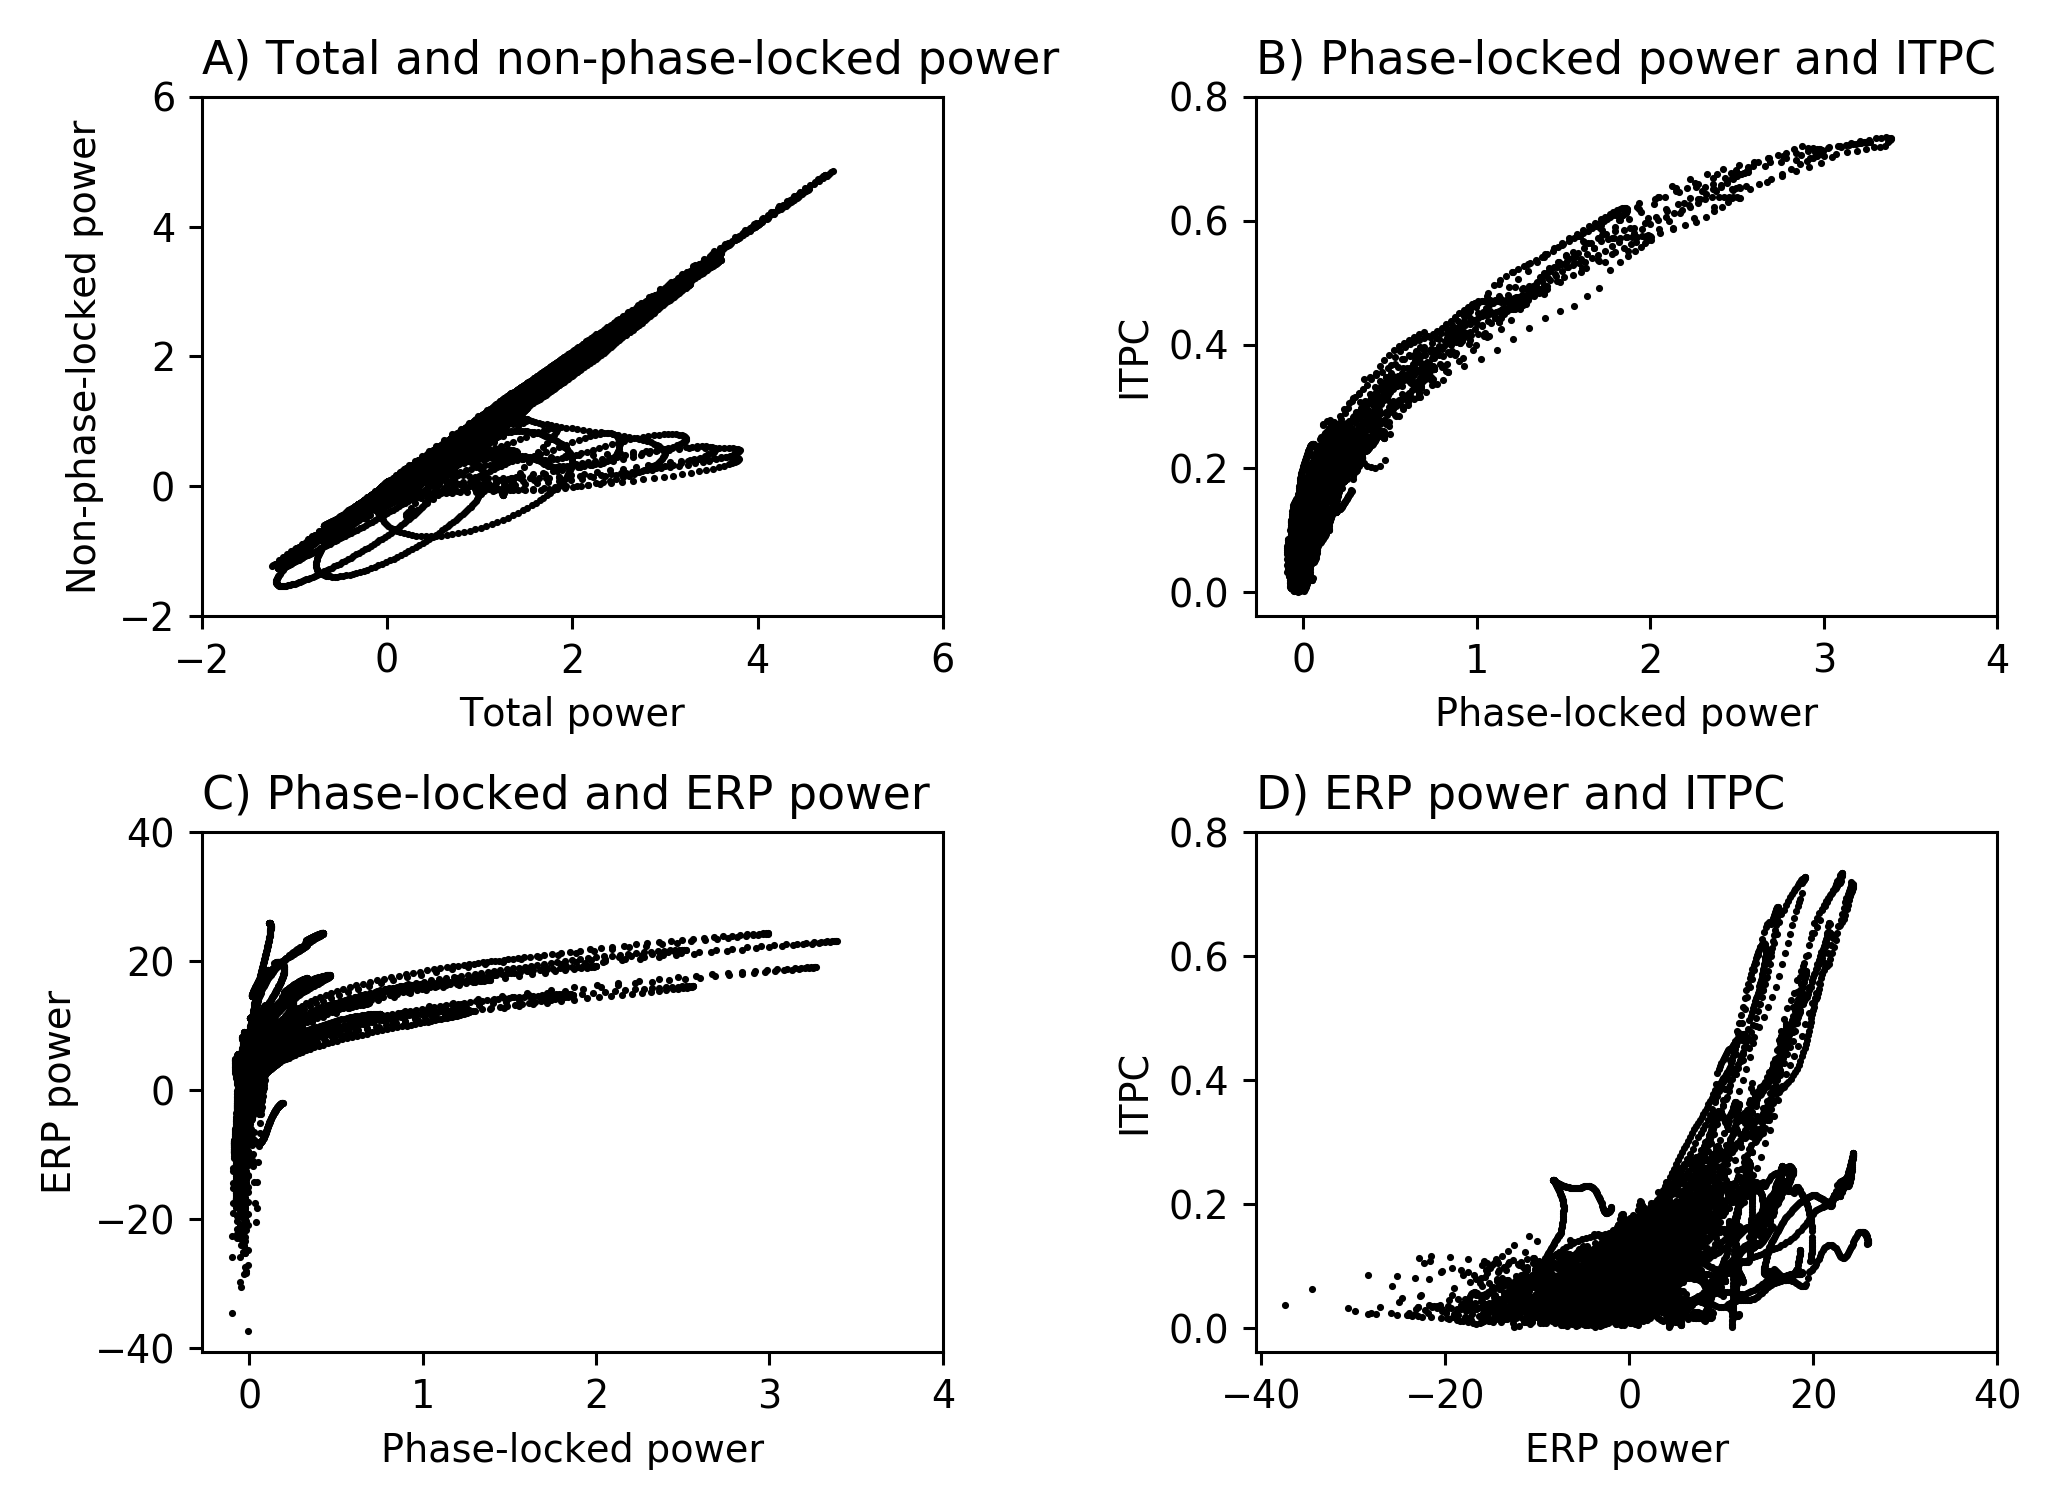

In [3]:
plt.rc('font', size=10)

# Flatten time-frequency array to 2 dimensions
tf_2d = np.real(np.reshape(tf, [np.shape(tf)[0], np.shape(tf)[1] * np.shape(tf)[2]], order='F'))

plot_idx = np.array([[0, 1], [2, 4], [2, 3], [3, 4]])
titles = ['Total and non-phase-locked power', 'Phase-locked power and ITPC',
          'Phase-locked and ERP power', 'ERP power and ITPC']
xlabs = ['Total', 'Phase-locked', 'Phase-locked', 'ERP']
ylabs = ['Non-phase-locked power', 'ITPC', 'ERP power', 'ITPC']
xticks = np.array([np.linspace(-2, 6, 5), np.arange(0, 5), np.arange(0, 5), np.linspace(-40, 40, 5)])
yticks = np.array([np.linspace(-2, 6, 5), np.linspace(0, .8, 5), np.linspace(-40, 40, 5), np.linspace(0, .8, 5)])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 5.5))

j = 0
for i in ax.flatten():
    
    i.scatter(tf_2d[plot_idx[j, 0], :], tf_2d[plot_idx[j, 1], :], s=.75, color='black')
    i.set_xlabel(xlabs[j] + ' power')
    i.set_ylabel(ylabs[j])
    i.set_xticks(xticks[j])
    i.set_yticks(yticks[j])
    i.set_title(pos_to_char(j) + ') ' + titles[j], loc='left')
    j += 1

fig.tight_layout()